# Load packages and set data path

In [3]:
from utils.data import ETZ
import torch
import os
import random
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage.measure import label, regionprops
import re
import matplotlib.patches as patches
from utils.data_path import *
from os.path import join as join_path
from pathlib import Path
from utils import raw_data_processing, plots, lesion_tools
from importlib import reload
from PIL import Image
from tqdm import tqdm
torch.cuda.is_available()

True

In [ ]:
reload(utils.data_path)

In [2]:
MASKS

'/wecare/projects/Slicer_ready_data/Original Patient Data/Corrected_labels_nii'

In [21]:
id_pattern = r'CTP[0-9]{2,3}_00[1|2]_[0-9]{4}'
id_aug_pattern = r'CTP[0-9]{2,3}_00[1|2]_[0-9]{4}_aug[0-9]{2}'

# Draw segmentation mask on a detection made by Yolov5

In [10]:
image_id = Path("fold_2/CTP70_001_0197.png")
image_path = Path(AUGMENTED_SCANS) / image_id
mask_path = Path(AUGMENTED_MASKS) / image_id
detect_path_predict = Path(RUNS_YOLOV5) / "detect/holdout_1" / image_id
detect_path_crop_predicts = list((Path(RUNS_YOLOV5) / "detect/holdout_1" / image_id.parts[0] / "crops/lesion").glob(f"{image_id.stem}*.jpg"))
detect_path_crop_true = list((Path(RUNS_YOLOV5) / "detect/holdout_1_true" / image_id.parts[0] / "crops/lesion").glob(f"{image_id.stem}*.png"))

In [11]:
import torchvision
from torchvision.utils import draw_segmentation_masks
from torchvision.io import read_image

image = read_image(str(image_path), mode = torchvision.io.ImageReadMode.GRAY)[0].numpy()
mask = read_image(str(mask_path), mode = torchvision.io.ImageReadMode.GRAY)[0].numpy()

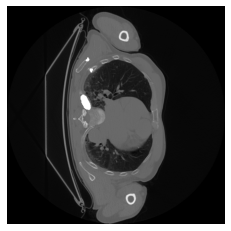

In [119]:
image_cop = image.copy()
image_cop[mask == 255] = 255
plt.figsize = (3, 3)
plt.imshow(image_cop)
#plt.subplots_adjust(left = 0.5, right = 0.7, bottom = 0.5, top = 0.7)
plt.axis("off")
plt.savefig(Path(ROOT) / "figures/sample_correct_detection" / "CTP70_001_0197_lesionColored.png", format = "png", facecolor = "black",
           bbox_inches = 'tight')

# Draw segmentation mask on some example

In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [15]:
PROCESSED_SCANS

'/wecare/home/khoi/thesis/ct_processed/images'

In [21]:
cv2.imread('/wecare/home/khoi/thesis/ct_processed/images/fold_4/CTP10_001_0089.png', cv2.IMREAD_GRAYSCALE)

[ WARN:0@691271.267] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/wecare/home/khoi/thesis/ct_processed/images/fold_4/CTP10_001_0089.png'): can't open/read file: check file path/integrity


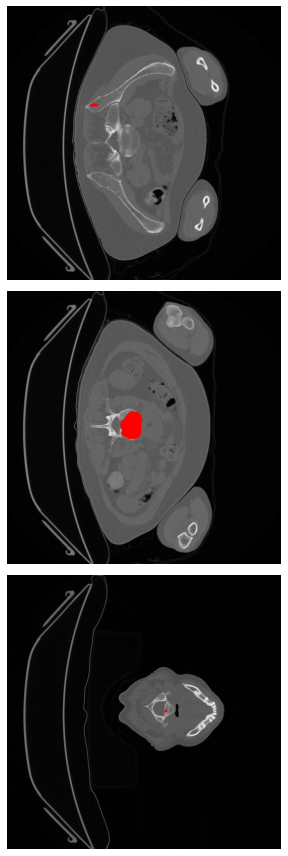

In [41]:
fig, axs = plt.subplots(3,1, figsize =  (6, 12))
ids = ["fold_4/CTP10_001_0058", "fold_4/CTP10_001_0089", "fold_4/CTP10_001_0269"]
img_ids = [str((Path(AUGMENTED_SCANS) / rel_id).with_suffix('.png')) for rel_id in ids]
mask_ids = [str((Path(AUGMENTED_MASKS) / rel_id).with_suffix('.png')) for rel_id in ids]

[axi.set_axis_off() for axi in axs.ravel()]
fig.tight_layout()
for i, (img_id, mask_id) in enumerate(zip(img_ids, mask_ids)):
    img, mask = cv2.imread(img_id, cv2.IMREAD_GRAYSCALE), cv2.imread(mask_id, cv2.IMREAD_GRAYSCALE)
    img, mask = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB), cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    # Color mask with red
    img[(mask == 255).all(-1)] = [255,0,0]
    axs[i].imshow(img, cmap = plt.gray())
    #axs[i, 1].imshow(mask, cmap = plt.gray())

In [42]:
fig.savefig(Path(ROOT) / "figures/org_dataset_sample" / "scans_annotated.png", format = "png", facecolor = "white", dpi = 300)

## Loading 10 random slices + mask with lesions

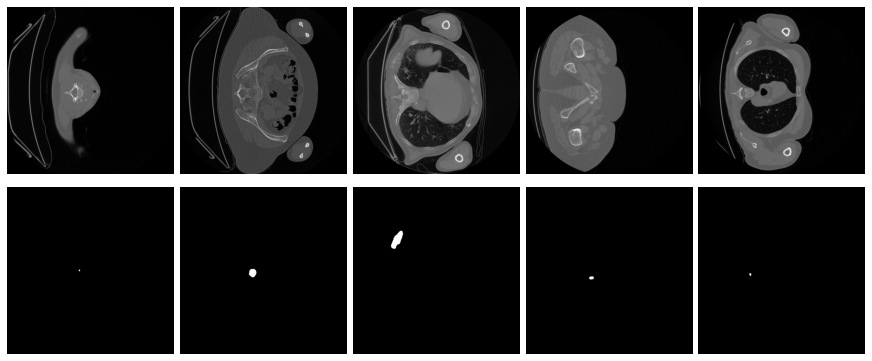

In [84]:
# Load 2 random from each fold
"""
From each fold folder, load 2 random pairs of images and masks wit lesiosn. Then plot them and draw bounding boxes
"""
random.seed(99)
fig, axs = plt.subplots(2, 5, figsize = (12, 5), constrained_layout = True)
#fig.tight_layout()
#fig.subplots_adjust(wspace = 0.1, hspace = 0.1)
path_list = []
for fold in range(1,6):
    all_labels = list(map(lambda x: x.stem ,(Path(AUGMENTED_LABELS) / f"fold_{fold}").glob("*.txt"))) # list of all slices that have lesions
    idx = random.choice(all_labels)
    
    while "aug" in idx:
        idx = random.choice(all_labels)
    #rect_0 = patches.Rectangle((x_anchor, y_anchor), bbox_width, bbox_height, edgecolor = 'r', linewidth = 1)
    scan_path = str((Path(AUGMENTED_SCANS) / f"fold_{fold}" / idx).with_suffix(".png"))
    mask_path = str((Path(AUGMENTED_MASKS) / f"fold_{fold}" / idx).with_suffix(".png"))
    path_list.append((scan_path, mask_path))
    scan = read_image(scan_path, mode = torchvision.io.ImageReadMode.GRAY)[0]
    mask = read_image(mask_path, mode = torchvision.io.ImageReadMode.GRAY)[0]
    axs[0][fold - 1].axis("off")
    axs[1][fold - 1].axis("off")
    axs[0][fold - 1].imshow(scan, cmap = plt.gray())
    axs[1][fold - 1].imshow(mask, cmap = plt.gray())
fig.savefig(Path(ROOT) / "figures/random_figs" / "original_scans", format = "png", facecolor = "white")

## Loading 10 random augmented slices + masks with lesions

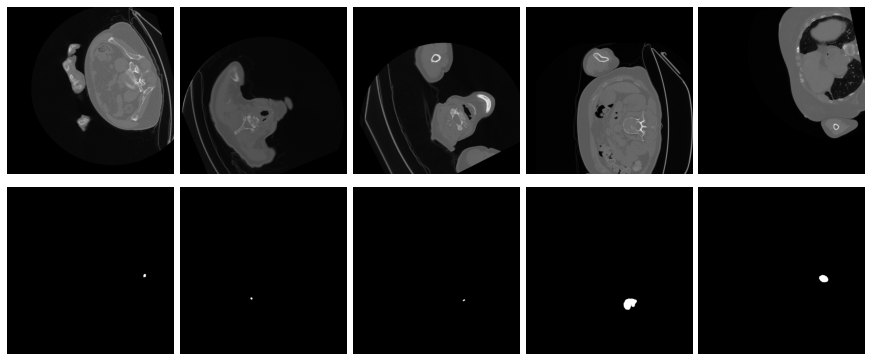

In [83]:
# Load 2 random from each fold
"""
From each fold folder, load 2 random pairs of images and masks wit lesiosn. Then plot them and draw bounding boxes
"""
random.seed(99)
fig, axs = plt.subplots(2, 5, figsize = (12, 5), constrained_layout = True)
#fig.tight_layout()
#fig.subplots_adjust(wspace = 0.1, hspace = 0.1)
path_aug_list = []
for fold in range(1,6):
    all_labels = list(map(lambda x: x.stem ,(Path(AUGMENTED_LABELS) / f"fold_{fold}").glob("*.txt"))) # list of all slices that have lesions
    idx = random.choice(all_labels)
    
    while "aug" not in idx:
        idx = random.choice(all_labels)
    #rect_0 = patches.Rectangle((x_anchor, y_anchor), bbox_width, bbox_height, edgecolor = 'r', linewidth = 1)
    scan_path = str((Path(AUGMENTED_SCANS) / f"fold_{fold}" / idx).with_suffix(".png"))
    mask_path = str((Path(AUGMENTED_MASKS) / f"fold_{fold}" / idx).with_suffix(".png"))
    path_aug_list.append((scan_path, mask_path))
    scan = read_image(scan_path, mode = torchvision.io.ImageReadMode.GRAY)[0]
    mask = read_image(mask_path, mode = torchvision.io.ImageReadMode.GRAY)[0]
    axs[0][fold - 1].axis("off")
    axs[1][fold - 1].axis("off")
    axs[0][fold - 1].imshow(scan, cmap = plt.gray())
    axs[1][fold - 1].imshow(mask, cmap = plt.gray())
fig.savefig(Path(ROOT) / "figures/random_figs" / "augmented_scans", format = "png", facecolor = "white")

## PLoting predictions made by Yolov5

In [75]:
image_id = Path("fold_2/CTP70_001_0197.png")
image_path = Path(AUGMENTED_SCANS) / image_id
mask_path = Path(AUGMENTED_MASKS) / image_id
detect_path_predict = Path(RUNS_YOLOV5) / "detect/holdout_1"
detect_path_crop_predicts = list((Path(RUNS_YOLOV5) / "detect/holdout_1" / image_id.parts[0] / "crops/lesion").glob(f"{image_id.stem}*.jpg"))
detect_path_crop_true = list((Path(RUNS_YOLOV5) / "detect/holdout_1_true" / image_id.parts[0] / "crops/lesion").glob(f"{image_id.stem}*.png"))

In [82]:
detect_path_predict = Path(RUNS_YOLOV5) / "detect/holdout_1/fold_1"
len(list(detect_path_predict.glob("*.png")))

13011

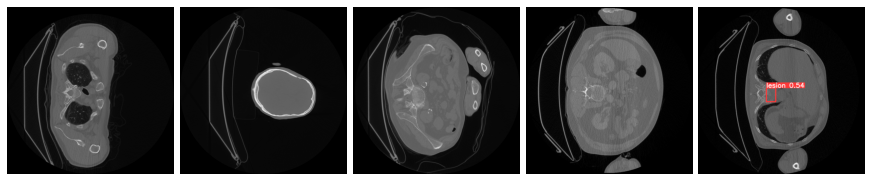

In [97]:
# Load 2 random from each fold
"""
From each fold folder, load 2 random pairs of images and masks wit lesiosn. Then plot them and draw bounding boxes
"""
detect_path_predict = Path(RUNS_YOLOV5) / "detect/holdout_1"
#random.seed(17)
fig, axs = plt.subplots(1, 5, figsize = (12, 10), constrained_layout = True)
[axi.set_axis_off() for axi in axs.ravel()]
#fig.tight_layout()
#fig.subplots_adjust(wspace = 0.1, hspace = 0.1)
preds_list = []
over_detect = False
for fold in range(1,6):
    pred_path = detect_path_predict / f"fold_{fold}"
    all_preds = list(pred_path.glob("*.png"))
    while over_detect == False:
        idx = random.choice(all_preds)
        mask = np.asarray(Image.open(join_path(AUGMENTED_MASKS, Path(idx).parts[-2], Path(idx).parts[-1])).convert('L'))
        if len(np.unique(mask)) == 1:
            over_detect = True
    # print(mask)
    # axs[0, fold - 1].imshow(mask)
    true_bboxes = plots.bbox_overlay(mask, 'blue', 1)
    pred = mpimg.imread(str(pred_path / idx))
    #pred = read_image(str(pred_path / idx))[0]
    axs[fold - 1].imshow(pred)
    for bbox in true_bboxes:
        #print(bbox.get_bbox())
        axs[fold - 1].add_patch(bbox)
    over_detect = False
    preds_list.append(f"fold_{fold}/{idx}")

In [31]:
mask.shape

(768, 768, 4)

In [30]:
lesion_tools.get_lesion_props(mask, 0.0)[0].bbox

(0, 0, 0, 768, 768, 4)

In [98]:
fig.savefig(Path(ROOT) / "figures/random_figs" / "yolov5_preds_8", format = "png", facecolor = "white", dpi = 300)

# Dataset analyse

## CT scans distribution

In [36]:
upper_or_whole = 0
lower = 0
patient_nums = set()
regex = r'CTP([0-9]{2,3})_(00[1|2])_0000'
for scan in os.listdir(CT_SCANS):
    scan_pattern = re.search(regex, scan)
    num = scan_pattern.group(1)
    patient_nums.add(num)
    if scan_pattern.group(2) == '001':
        upper_or_whole += 1
    else:
        lower += 1

In [37]:
print(f"There are in total {len(os.listdir(CT_SCANS))} CT scans")
print(f"There are {upper_or_whole} upper or whole body scans, {lower} body scans. There are in total {len(patient_nums)} patients")

There are in total 96 CT scans
There are 79 upper or whole body scans, 17 body scans. There are in total 79 patients


In [42]:
num_lesions = 0
num_slices_with_lesions = len(list(Path(PROCESSED_LABELS).rglob("*.txt")))
i = 0
for slc in Path(PROCESSED_LABELS).rglob("*.txt"):
    num_lesions += len(open(slc, "r").readlines())

In [43]:
print(f"There are in total {num_slices_with_lesions} slices with lesions, and {num_lesions} lesions in total")

There are in total 2265 slices with lesions, and 2813 lesions in total


In [4]:
num_slices_org = 0
num_slices_aug = 0
for fold in range(1,6):
    org_image_path = Path(PROCESSED_SCANS) / f"fold_{fold}"
    aug_image_path = Path(AUGMENTED_SCANS) / f"fold_{fold}"
    num_slices_org += len(os.listdir(str(org_image_path)))
    num_slices_aug += len(os.listdir(str(aug_image_path)))

In [5]:
print(f"There are in total {num_slices_org} original scan slices, {num_slices_aug} slices after augmenting")

There are in total 43996 original scan slices, 66646 slices after augmenting


## Analyse lesion properties

In [3]:
for i, pth in enumerate(Path(MASKS).glob("*")):
    if i < 3:
        print(pth)
    else:
        break

/wecare/projects/Slicer_ready_data/Original Patient Data/Corrected_labels_nii/CTP15_002_1.nii
/wecare/projects/Slicer_ready_data/Original Patient Data/Corrected_labels_nii/CTP46_001_1.nii
/wecare/projects/Slicer_ready_data/Original Patient Data/Corrected_labels_nii/CTP83_001_1.nii


In [4]:
global_areas = []
slices_count = []
#volumes = []
pre_process = raw_data_processing.Data_processing()
i = 0
for i, mask_file in tqdm(enumerate(Path(MASKS).glob("*"))):
    mask_3D, header = pre_process.Loading_Nifti_data(MASKS, [mask_file])
    mask_3D, header =  mask_3D[0], header[0]
    slices_count.append(mask_3D.shape[-1])
    # Calculate unit area
    unit_area = header["pixdim"][1] * header["pixdim"][2]
    # Create a list to store area information for each scan
    scan_areas = []
    # Calculate the area for each slice
    for i in range(mask_3D.shape[-1]):
        slice_ = mask_3D[:, :, i]
        lesion_props = lesion_tools.get_lesion_props(slice_, 0.0)
        if len(lesion_props) > 0:
            temp_areas = []
            for lesion in lesion_props:
                mm_area = lesion.area * unit_area
                temp_areas.append(mm_area)
            scan_areas.append(temp_areas)
    #print(f"{mask_file}: {scan_areas}")
    global_areas.append(scan_areas)

0it [00:00, ?it/s]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


---Nifti Data loaded Succesfully!---


1it [00:01,  1.72s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


---Nifti Data loaded Succesfully!---


2it [00:03,  1.75s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.92s/it]


---Nifti Data loaded Succesfully!---


3it [00:14,  6.17s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.63s/it]


---Nifti Data loaded Succesfully!---


4it [00:24,  7.44s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.23s/it]


---Nifti Data loaded Succesfully!---


5it [00:33,  8.04s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]


---Nifti Data loaded Succesfully!---


6it [00:38,  7.20s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.95s/it]


---Nifti Data loaded Succesfully!---


7it [00:49,  8.16s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.80s/it]


---Nifti Data loaded Succesfully!---


8it [00:57,  8.17s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]


---Nifti Data loaded Succesfully!---


9it [01:01,  6.80s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.25s/it]


---Nifti Data loaded Succesfully!---


10it [01:06,  6.40s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


---Nifti Data loaded Succesfully!---


11it [01:09,  5.34s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.08s/it]


---Nifti Data loaded Succesfully!---


12it [01:14,  5.11s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.24s/it]


---Nifti Data loaded Succesfully!---


13it [01:17,  4.46s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.36s/it]


---Nifti Data loaded Succesfully!---


14it [01:26,  5.96s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it]


---Nifti Data loaded Succesfully!---


15it [01:29,  5.00s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.08it/s]

---Nifti Data loaded Succesfully!---



16it [01:29,  3.68s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


---Nifti Data loaded Succesfully!---


17it [01:31,  3.00s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


---Nifti Data loaded Succesfully!---


18it [01:34,  3.01s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


---Nifti Data loaded Succesfully!---


19it [01:37,  3.19s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


---Nifti Data loaded Succesfully!---


20it [01:41,  3.43s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.89s/it]


---Nifti Data loaded Succesfully!---


21it [01:47,  4.17s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


---Nifti Data loaded Succesfully!---


22it [01:56,  5.44s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


---Nifti Data loaded Succesfully!---


23it [01:59,  4.80s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


---Nifti Data loaded Succesfully!---


24it [02:01,  3.98s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


---Nifti Data loaded Succesfully!---


25it [02:06,  4.24s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


---Nifti Data loaded Succesfully!---


26it [02:10,  4.27s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


---Nifti Data loaded Succesfully!---


27it [02:12,  3.46s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


---Nifti Data loaded Succesfully!---


28it [02:14,  2.98s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


---Nifti Data loaded Succesfully!---


29it [02:15,  2.41s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


---Nifti Data loaded Succesfully!---


30it [02:17,  2.31s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


---Nifti Data loaded Succesfully!---


31it [02:19,  2.28s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


---Nifti Data loaded Succesfully!---


32it [02:21,  2.09s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


---Nifti Data loaded Succesfully!---


33it [02:23,  2.21s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.98s/it]


---Nifti Data loaded Succesfully!---


34it [02:29,  3.21s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.33s/it]


---Nifti Data loaded Succesfully!---


35it [02:36,  4.26s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


---Nifti Data loaded Succesfully!---


36it [02:41,  4.57s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


---Nifti Data loaded Succesfully!---


37it [02:43,  3.99s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


---Nifti Data loaded Succesfully!---


38it [02:46,  3.65s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


---Nifti Data loaded Succesfully!---


39it [02:48,  3.13s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.01s/it]


---Nifti Data loaded Succesfully!---


40it [03:00,  5.82s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


---Nifti Data loaded Succesfully!---


41it [03:02,  4.65s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


---Nifti Data loaded Succesfully!---


42it [03:04,  3.71s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


---Nifti Data loaded Succesfully!---


43it [03:05,  2.90s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]


---Nifti Data loaded Succesfully!---


44it [03:08,  2.89s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


---Nifti Data loaded Succesfully!---


45it [03:11,  2.98s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


---Nifti Data loaded Succesfully!---


46it [03:12,  2.38s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


---Nifti Data loaded Succesfully!---


47it [03:14,  2.27s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.53s/it]


---Nifti Data loaded Succesfully!---


48it [03:19,  3.17s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


---Nifti Data loaded Succesfully!---


49it [03:20,  2.58s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.37s/it]


---Nifti Data loaded Succesfully!---


50it [03:30,  4.68s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


---Nifti Data loaded Succesfully!---


51it [03:32,  3.99s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


---Nifti Data loaded Succesfully!---


52it [03:35,  3.73s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


---Nifti Data loaded Succesfully!---


53it [03:38,  3.45s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


---Nifti Data loaded Succesfully!---


54it [03:40,  2.99s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


---Nifti Data loaded Succesfully!---


55it [03:41,  2.50s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


---Nifti Data loaded Succesfully!---


56it [03:43,  2.18s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.02s/it]


---Nifti Data loaded Succesfully!---


57it [03:47,  2.82s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/it]


---Nifti Data loaded Succesfully!---


58it [03:53,  3.74s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


---Nifti Data loaded Succesfully!---


59it [03:56,  3.50s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


---Nifti Data loaded Succesfully!---


60it [03:57,  2.78s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


---Nifti Data loaded Succesfully!---


61it [04:01,  3.15s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.89s/it]


---Nifti Data loaded Succesfully!---


62it [04:05,  3.47s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.87s/it]


---Nifti Data loaded Succesfully!---


63it [04:10,  3.75s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


---Nifti Data loaded Succesfully!---


64it [04:11,  3.05s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.17s/it]


---Nifti Data loaded Succesfully!---


65it [04:22,  5.49s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


---Nifti Data loaded Succesfully!---


66it [04:25,  4.60s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


---Nifti Data loaded Succesfully!---


67it [04:27,  3.94s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


---Nifti Data loaded Succesfully!---


68it [04:31,  3.89s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.37s/it]


---Nifti Data loaded Succesfully!---


69it [04:36,  4.12s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


---Nifti Data loaded Succesfully!---


70it [04:37,  3.40s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


---Nifti Data loaded Succesfully!---


71it [04:39,  2.92s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


---Nifti Data loaded Succesfully!---


72it [04:41,  2.56s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


---Nifti Data loaded Succesfully!---


73it [04:43,  2.51s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


---Nifti Data loaded Succesfully!---


74it [04:45,  2.32s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


---Nifti Data loaded Succesfully!---


75it [04:47,  2.19s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


---Nifti Data loaded Succesfully!---


76it [04:54,  3.73s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


---Nifti Data loaded Succesfully!---


77it [05:03,  5.24s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]


---Nifti Data loaded Succesfully!---


78it [05:09,  5.38s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]


---Nifti Data loaded Succesfully!---


79it [05:12,  4.78s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


---Nifti Data loaded Succesfully!---


80it [05:20,  5.70s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.20s/it]


---Nifti Data loaded Succesfully!---


81it [05:25,  5.40s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


---Nifti Data loaded Succesfully!---


82it [05:32,  5.93s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


---Nifti Data loaded Succesfully!---


83it [05:33,  4.58s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.34s/it]


---Nifti Data loaded Succesfully!---


84it [05:43,  6.19s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


---Nifti Data loaded Succesfully!---


85it [05:48,  5.66s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


---Nifti Data loaded Succesfully!---


86it [05:49,  4.35s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


---Nifti Data loaded Succesfully!---


87it [05:52,  3.78s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]


---Nifti Data loaded Succesfully!---


88it [05:53,  2.96s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


---Nifti Data loaded Succesfully!---


89it [05:54,  2.62s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.97s/it]


---Nifti Data loaded Succesfully!---


90it [06:03,  4.31s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.17s/it]


---Nifti Data loaded Succesfully!---


91it [06:07,  4.42s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


---Nifti Data loaded Succesfully!---


92it [06:10,  3.74s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.41s/it]


---Nifti Data loaded Succesfully!---


93it [06:21,  6.03s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.86s/it]


---Nifti Data loaded Succesfully!---


94it [06:24,  5.01s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]


---Nifti Data loaded Succesfully!---


95it [06:26,  4.32s/it]

----Start Loading Files---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


---Nifti Data loaded Succesfully!---


96it [06:30,  4.06s/it]


In [8]:
np.array(slices_count)

array([406, 283, 730, 674, 704, 702, 723, 553, 637, 528, 247, 340, 352,
       706, 426, 207, 525, 313, 608, 662, 682, 592, 549, 277, 706, 725,
       379, 309, 377, 342, 363, 278, 304, 584, 540, 707, 306, 295, 295,
       695, 316, 339, 353, 406, 534, 342, 316, 621, 407, 723, 400, 412,
       308, 280, 349, 362, 285, 702, 309, 382, 658, 301, 577, 343, 683,
       297, 326, 633, 288, 436, 345, 428, 287, 353, 312, 577, 613, 603,
       317, 521, 333, 586, 367, 644, 533, 342, 353, 387, 480, 680, 343,
       371, 680, 380, 441, 401])

In [9]:
[func(np.array(slices_count)) for func in [np.min, np.max, np.mean, np.std]]

[207, 730, 458.2916666666667, 153.9919449101875]

In [23]:
global_areas_f = [area for scan_areas in global_areas for slice_areas in scan_areas for area in slice_areas]
global_areas_f[:10]

[27.656527519226074,
 45.77632141113281,
 43.868974685668945,
 66.75713539123535,
 53.40570831298828,
 9.536733627319336,
 66.75713539123535,
 44.82264804840088,
 23.84183406829834,
 38.146934509277344]

In [24]:
global_areas_arr = np.array(global_areas_f)

Text(30, -100, '19.63 - lesion breakpoint')

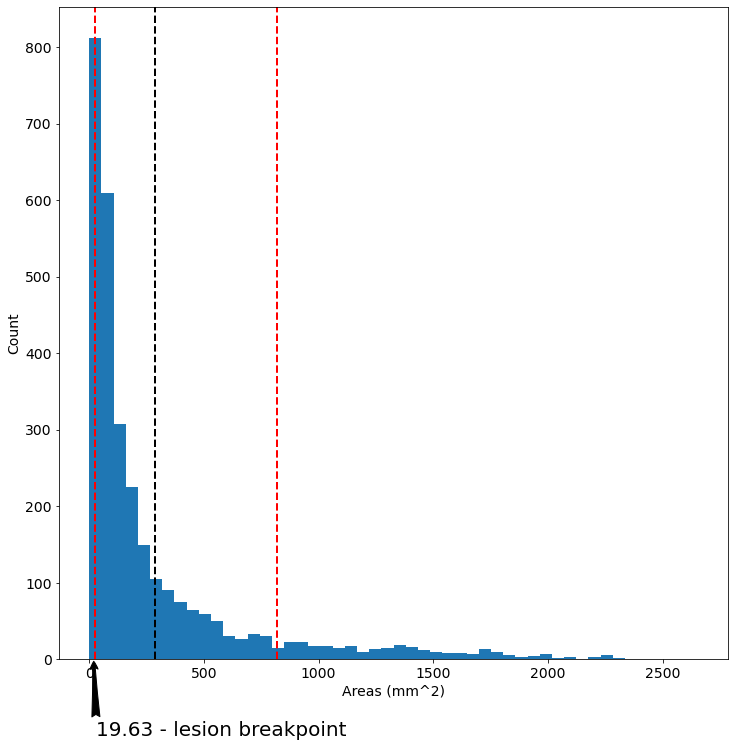

In [78]:
fig, axs = plt.subplots(1,1, figsize = (12, 12))
axs.set_xlabel("Areas (mm^2)", fontsize = 14)
axs.set_ylabel("Count", fontsize = 14)
axs.hist(global_areas_arr, bins = 50)
axs.tick_params(labelsize = 14)
axs.tick_params(labelsize = 14)
#axs.set_xticks([0, 19.63, global_areas_arr.mean(), np.quantile(global_areas_arr, 0.9), 1000, 1500, 2000, 2500])
axs.axvline(global_areas_arr.mean(), color = 'k', linestyle = 'dashed', linewidth = 2)
axs.axvline(np.quantile(global_areas_arr, 0.1), color = 'red', linestyle = 'dashed', linewidth = 2)
axs.axvline(np.quantile(global_areas_arr, 0.9), color = 'red', linestyle = 'dashed', linewidth = 2)
axs.annotate('19.63 - lesion breakpoint', xy = (19.63, 0), xytext = (30, -100), arrowprops = dict(arrowstyle = "fancy", relpos = (0,1), facecolor = 'black'), fontsize = 20)
#axs.axvline(19.63, color = 'green', linestyle = 'dashed', linewidth = 1)

In [82]:
global_areas_arr.shape, np.min(global_areas_arr), np.max(global_areas_arr)

((2972,), 0.3857574462890625, 2653.723663687706)

In [83]:
np.mean(global_areas_arr), np.std(global_areas_arr)

(288.29039395903897, 411.5894532790371)

In [79]:
fig.savefig(Path(ROOT) / "figures/random_figs" / "lesion_dist.png", format = "png", facecolor = "white", dpi = 300)

In [20]:
slice_avgs = [[sum(slice_areas) / len(slice_areas) for slice_areas in scan_areas] for scan_areas in global_areas]

In [ ]:
scan_avgs = [for ]

In [15]:
foo = global_areas[0]
for x in foo:
    #print(x)
    print(sum(x) / len(x))

27.656527519226074
44.82264804840088
60.081421852111816
40.372172355651855
30.994384288787842
18.755576133728027
9.536733627319336
20.98081398010254
34.33224105834961


## Lesion areas distribution

## Lesion volumes distribution